In [10]:
import OpenEXR
from pprint import pprint
import os
from os import path
import pandas as pd
import seaborn as sns

print("EXR Python Lib loaded from:", OpenEXR.__file__)
print("Current working directory:", os.getcwd())

EXR Python Lib loaded from: /usr/lib/python3.10/OpenEXR.so
Current working directory: /mnt/c/Jupyter/testimages


In [2]:
# EXR test files we'll use in this benchmark example
input_filenames = ["ACES.StillLife.exr", 
                   "HDRSurvey_GoldenGate.exr",
                   "OpenEXR.Desk.exr"]

# Testing compression methods that we will use (including NO_COMPRESSION)
compression_methods = [(OpenEXR.NO_COMPRESSION, "raw"),
                       (OpenEXR.RLE_COMPRESSION, "rle"),
                       (OpenEXR.ZIPS_COMPRESSION, "zips"),
                       (OpenEXR.ZIP_COMPRESSION, "zip"),
                       (OpenEXR.PIZ_COMPRESSION, "piz"),
                       (OpenEXR.PXR24_COMPRESSION, "pxr24"),
                       (OpenEXR.B44_COMPRESSION, "b44"),
                       (OpenEXR.B44A_COMPRESSION, "b44a"),
                       (OpenEXR.DWAA_COMPRESSION, "dwaa"),
                       (OpenEXR.DWAB_COMPRESSION, "dwab")]

In [3]:
# Routine for write out an exr file with a given compression type
def reCompressThenLoad(exrFile, fileName, compressionType):
    header = exrFile.header()
    header["compression"] = compressionType
    exrFile.write(fileName)
    return path.getsize(fileName)
    

## Iterate through the given test exr files, and record following data:
1. Raw bytestream size according to header data
2. File size using different compression method, including NO_Compression



In [4]:
records = []

for fn in input_filenames:
    desc = {}    
    assert(fn.endswith(".exr"))
    infile = OpenEXR.File(fn)
    desc["filename"] = fn
    header = infile.header()
    original_compression = header["compression"]
    original_filesize = path.getsize(fn)
    desc[original_compression.name] = original_filesize
    
    for method, shortname in compression_methods:
        if method != original_compression:
            new_fn = fn[:-4]+".{}.exr".format(shortname)
            filesize = reCompressThenLoad(infile, new_fn, method)
            desc[method.name] = filesize
    records.append(desc)
            
pprint(records)


[{'B44A_COMPRESSION': 5832905,
  'B44_COMPRESSION': 7258626,
  'DWAA_COMPRESSION': 3934656,
  'DWAB_COMPRESSION': 3843739,
  'NO_COMPRESSION': 16606512,
  'PIZ_COMPRESSION': 8915009,
  'PXR24_COMPRESSION': 9367481,
  'RLE_COMPRESSION': 11673017,
  'ZIPS_COMPRESSION': 9049257,
  'ZIP_COMPRESSION': 8734671,
  'filename': 'ACES.StillLife.exr'},
 {'B44A_COMPRESSION': 32058776,
  'B44_COMPRESSION': 32058875,
  'DWAA_COMPRESSION': 11721309,
  'DWAB_COMPRESSION': 11539100,
  'NO_COMPRESSION': 73293531,
  'PIZ_COMPRESSION': 35698983,
  'PXR24_COMPRESSION': 43568864,
  'RLE_COMPRESSION': 52380021,
  'ZIPS_COMPRESSION': 39604649,
  'ZIP_COMPRESSION': 38635770,
  'filename': 'HDRSurvey_GoldenGate.exr'},
 {'B44A_COMPRESSION': 1587484,
  'B44_COMPRESSION': 1975333,
  'DWAA_COMPRESSION': 1108575,
  'DWAB_COMPRESSION': 1042082,
  'NO_COMPRESSION': 4517213,
  'PIZ_COMPRESSION': 2424523,
  'PXR24_COMPRESSION': 2472199,
  'RLE_COMPRESSION': 3122302,
  'ZIPS_COMPRESSION': 2573299,
  'ZIP_COMPRESSION': 23

In [33]:
# Arrange by file name in a data frame for the compression ratios


for method, shortname in compression_methods:
    if method!= OpenEXR.NO_COMPRESSION:
        header.append(shortname)

df_data = []
header_row = ["Compression"]
for r in records:
    header_row.append(r["filename"])

for method, shortname in compression_methods:
    if method != OpenEXR.NO_COMPRESSION:
        df_row = [shortname]
        for r in records:
            raw_size = float(r[OpenEXR.NO_COMPRESSION.name])
            df_row.append(float(r[method.name])/raw_size)
        df_data.append(df_row)
            
df = pd.DataFrame(df_data)
df.columns = header_row

print(df)
    

  Compression  ACES.StillLife.exr  HDRSurvey_GoldenGate.exr  OpenEXR.Desk.exr
0         rle            0.702918                  0.714661          0.691201
1        zips            0.544922                  0.540357          0.569665
2         zip            0.525979                  0.527138          0.511096
3         piz            0.536838                  0.487069          0.536730
4       pxr24            0.564085                  0.594444          0.547284
5         b44            0.437095                  0.437404          0.437290
6        b44a            0.351242                  0.437403          0.351430
7        dwaa            0.236935                  0.159923          0.245411
8        dwab            0.231460                  0.157437          0.230691


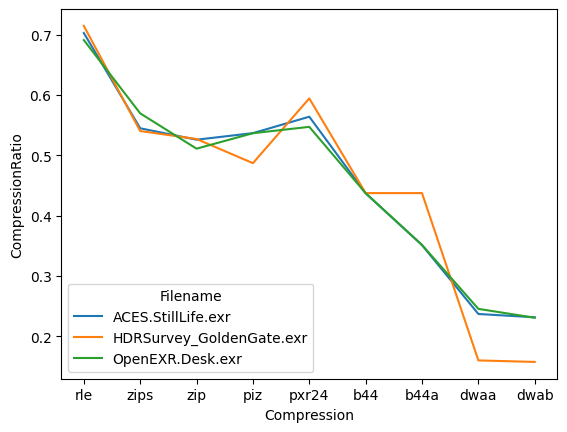

In [49]:
# Plot with Seaborn
dfm = df.melt(id_vars="Compression")
dfm.rename(columns={"variable": "Filename", "value": "CompressionRatio"}, inplace=True)
columns_to_plot = input_filenames

ax = sns.lineplot(data=dfm, x="Compression", y="CompressionRatio", hue="Filename")
